# LSTM

- reference: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Omajinai

In [1]:
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM #, GRU, Bidirectional
import tensorflow as tf

## Data

In [3]:
!wget https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv -O newly_confirmed_cases_daily.csv

--2022-04-21 23:42:38--  https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv
Resolving covid19.mhlw.go.jp (covid19.mhlw.go.jp)... 18.65.148.42, 18.65.148.47, 18.65.148.50, ...
Connecting to covid19.mhlw.go.jp (covid19.mhlw.go.jp)|18.65.148.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117757 (115K) [application/octet-stream]
Saving to: ‘newly_confirmed_cases_daily.csv’

newly_confirmed_cas 100%[===================>] 115.00K  --.-KB/s    in 0.04s   

2022-04-21 23:42:38 (3.17 MB/s) - ‘newly_confirmed_cases_daily.csv’ saved [117757/117757]



In [4]:
df = pd.read_csv('newly_confirmed_cases_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)
print(df.shape)
display(df.head(1))
display(df.tail(5))

(826, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-16,47543,2457,418,357,567,296,192,556,1034,552,...,275,147,2383,534,394,646,320,654,713,1439
2022-04-17,39214,2113,294,340,415,247,185,446,971,420,...,197,129,1996,248,346,475,274,548,662,1315
2022-04-18,24164,1766,153,188,219,182,130,316,845,356,...,125,77,1406,373,202,328,193,295,340,575
2022-04-19,40841,2067,429,281,583,363,203,504,549,713,...,400,160,2098,681,556,679,385,481,772,1547
2022-04-20,47842,3058,375,341,734,289,287,655,561,766,...,301,165,2415,569,575,777,360,570,806,1581


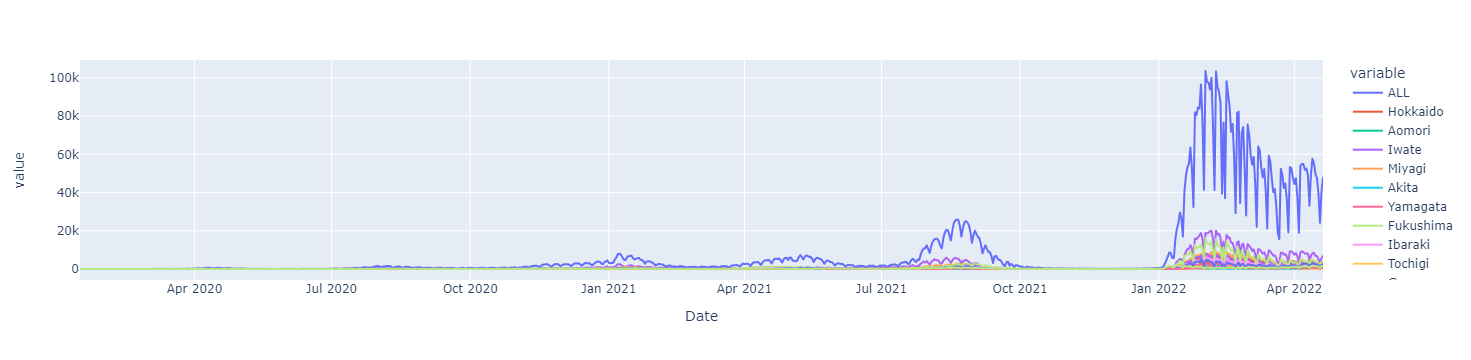

In [5]:
px.line(df, )

In [6]:
df_gr = df.groupby(pd.Grouper(level='Date', freq='W')).mean()
df_gr = df_gr.drop(df_gr.index[-1])
last_date = df_gr.index[-1]
print(df_gr.shape)
display(df_gr.head(1))
display(df_gr.tail(5))

(118, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-19,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-20,42726.571429,1453.857143,428.714286,237.000000,524.285714,200.857143,125.428571,341.142857,1434.714286,429.857143,...,234.428571,146.142857,1470.428571,246.571429,207.428571,463.571429,218.285714,225.428571,326.428571,636.428571
2022-03-27,37120.428571,1474.571429,410.285714,203.428571,453.000000,211.857143,88.571429,335.714286,1089.000000,448.000000,...,215.142857,121.428571,1351.428571,205.142857,180.428571,334.142857,238.714286,197.714286,413.000000,723.000000
2022-04-03,43211.000000,1600.285714,390.428571,209.714286,559.142857,252.571429,100.428571,425.857143,1303.857143,538.428571,...,243.285714,129.571429,1546.285714,324.857143,202.714286,458.285714,354.285714,336.142857,626.285714,987.428571
2022-04-10,48044.571429,2045.857143,464.857143,354.571429,584.285714,299.000000,140.285714,566.428571,1273.571429,629.571429,...,284.571429,144.142857,2224.285714,345.000000,315.714286,526.571429,406.285714,522.714286,633.000000,1212.857143
2022-04-17,47452.000000,2301.714286,414.285714,340.285714,538.571429,315.857143,208.571429,565.142857,1102.428571,587.285714,...,307.000000,150.428571,2369.857143,476.142857,409.142857,656.285714,391.000000,596.571429,641.142857,1350.285714


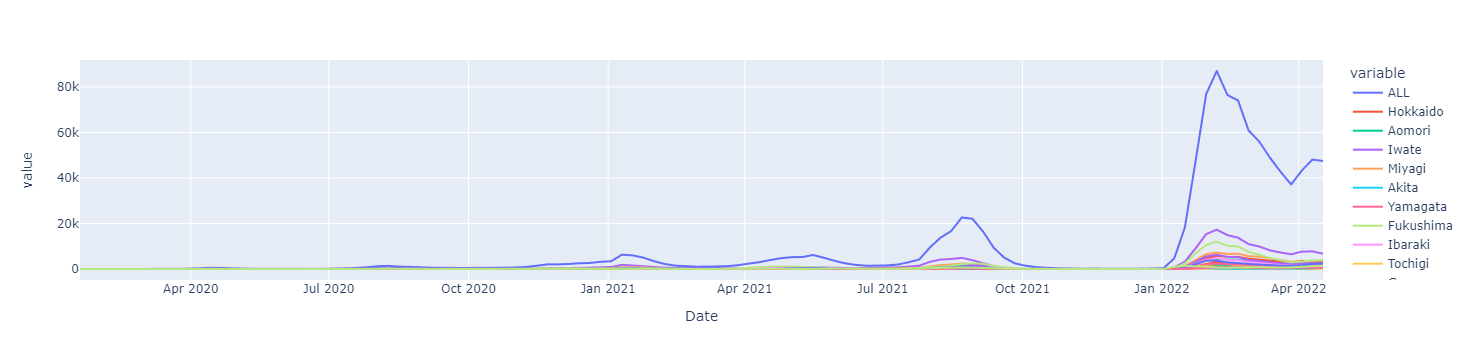

In [7]:
px.line(df_gr,)

### Scale

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
ts_all = df_gr.ALL
ts_all_sc = sc.fit_transform(ts_all.values.reshape(-1, 1)).ravel()
ts_all_sc = pd.Series(ts_all_sc, index=ts_all.index)
ts_all_sc.head(1)

Date
2020-01-19    0.0
Freq: W-SUN, dtype: float64

### FE

In [9]:
forecast_weeks = 12
# df_fe = df_gr.ALL.to_frame()
df_fe = ts_all_sc.to_frame(name='ALL')

# add new rows for forecast
index_list = pd.date_range(ts_all_sc.index[-1]+relativedelta(weeks=1), ts_all_sc.index[-1]+relativedelta(weeks=forecast_weeks), freq='W')
df_fe = pd.concat([df_fe, pd.DataFrame(index=index_list)])

# shift
for i in range(forecast_weeks, forecast_weeks+12):
    df_fe[f'ALL_{i}_week_ago'] = df_fe.ALL.shift(i)
# df_fe[f'ALL_12_week_ago'] = df_fe.ALL.shift(12)
df_fe['year'] = df_fe.index.year
df_fe['month'] = df_fe.index.month
df_fe['weekofyear'] = df_fe.index.isocalendar().week
df_fe = df_fe.astype('float')
df_fe = df_fe.loc[df_fe.ALL_23_week_ago.dropna().index, :]
df_fe

,ALL,ALL_12_week_ago,ALL_13_week_ago,ALL_14_week_ago,ALL_15_week_ago,ALL_16_week_ago,ALL_17_week_ago,ALL_18_week_ago,ALL_19_week_ago,ALL_20_week_ago,ALL_21_week_ago,ALL_22_week_ago,ALL_23_week_ago,year,month,weekofyear
2020-06-28,0.000915,0.003133,0.001283,0.000442,0.000521,0.000385,0.000181,0.000124,0.000022,0.000002,0.000010,0.000002,0.000000,2020.0,6.0,26.0
2020-07-05,0.002088,0.005712,0.003133,0.001283,0.000442,0.000521,0.000385,0.000181,0.000124,0.000022,0.000002,0.000010,0.000002,2020.0,7.0,27.0
2020-07-12,0.003470,0.005696,0.005712,0.003133,0.001283,0.000442,0.000521,0.000385,0.000181,0.000124,0.000022,0.000002,0.000010,2020.0,7.0,28.0
2020-07-19,0.005536,0.004365,0.005696,0.005712,0.003133,0.001283,0.000442,0.000521,0.000385,0.000181,0.000124,0.000022,0.000002,2020.0,7.0,29.0
2020-07-26,0.008501,0.002699,0.004365,0.005696,0.005712,0.003133,0.001283,0.000442,0.000521,0.000385,0.000181,0.000124,0.000022,2020.0,7.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-12,NaN,0.491296,0.562666,0.643348,0.698967,0.851436,0.879110,1.000000,0.883017,0.542872,0.210393,0.053491,0.004444,2022.0,6.0,23.0
2022-06-19,NaN,0.426833,0.491296,0.562666,0.643348,0.698967,0.851436,0.879110,1.000000,0.883017,0.542872,0.210393,0.053491,2022.0,6.0,24.0
2022-06-26,NaN,0.496866,0.426833,0.491296,0.562666,0.643348,0.698967,0.851436,0.879110,1.000000,0.883017,0.542872,0.210393,2022.0,6.0,25.0
2022-07-03,NaN,0.552446,0.496866,0.426833,0.491296,0.562666,0.643348,0.698967,0.851436,0.879110,1.000000,0.883017,0.542872,2022.0,7.0,26.0


### split

In [10]:
X = df_fe.drop('ALL', axis=1)
y = df_fe.ALL
print(X.shape, y.shape)

(107, 15) (107,)


## functions

In [11]:
# https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_loss = np.Inf
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        if loss < 0.001:
            if np.less(val_loss, self.best_val_loss):
                self.best_loss = loss
                self.best_val_loss = val_loss
                self.wait = 0
                # Record the best weights if current results is better (less).
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    self.model.set_weights(self.best_weights)

In [12]:
n_units = 4
dropout = 0.1
n_batch_size = 32
n_epochs = 10000

from keras.callbacks import EarlyStopping
es_loss = EarlyStopping(monitor='loss', patience=100)
es_val_loss = EarlyStopping(monitor='loss', patience=200)

def trainLSTM(X_train, y_train):
    tf.random.set_seed(42)
    
    # val
    X_val = X_train[X_train.index == X_train.index[-1]]
    X_train = X_train.drop(X_train.index[-1])
    y_val = y_train[y_train.index == y_train.index[-1]]
    y_train = y_train.drop(y_train.index[-1])
    
    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # Second LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Third LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Fourth LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fitting to the training set
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=n_epochs, batch_size=n_batch_size, verbose=0, 
        #callbacks=[es_loss]
        callbacks=[es_val_loss]
        #callbacks=[CustomEarlyStopping(patience=100)]
    )

    return model, history

## forecast

(95, 15) (95,)


2022-04-21 23:42:40.984012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-21 23:42:41.083485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-21 23:42:41.083994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-21 23:42:41.085898: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

loss: 0.014208
val_loss: 0.23358
CPU times: user 39.7 s, sys: 14.1 s, total: 53.8 s
Wall time: 42 s


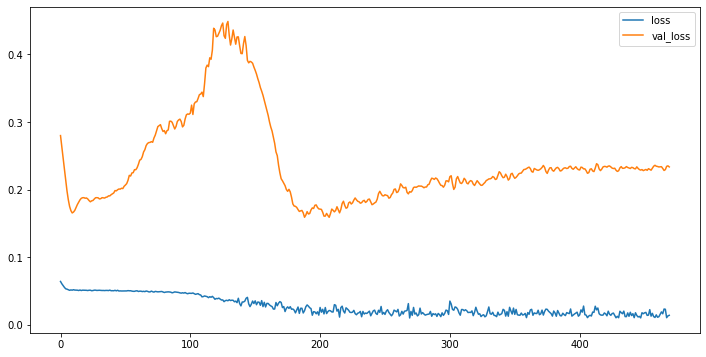

In [13]:
%%time

X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
print(X_train.shape, y_train.shape)

model, history = trainLSTM(X_train, y_train)
print('loss: {:.5}'.format(history.history['loss'][-1]))
print('val_loss: {:.5}'.format(history.history['val_loss'][-1]))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

RMSE: 8851.6


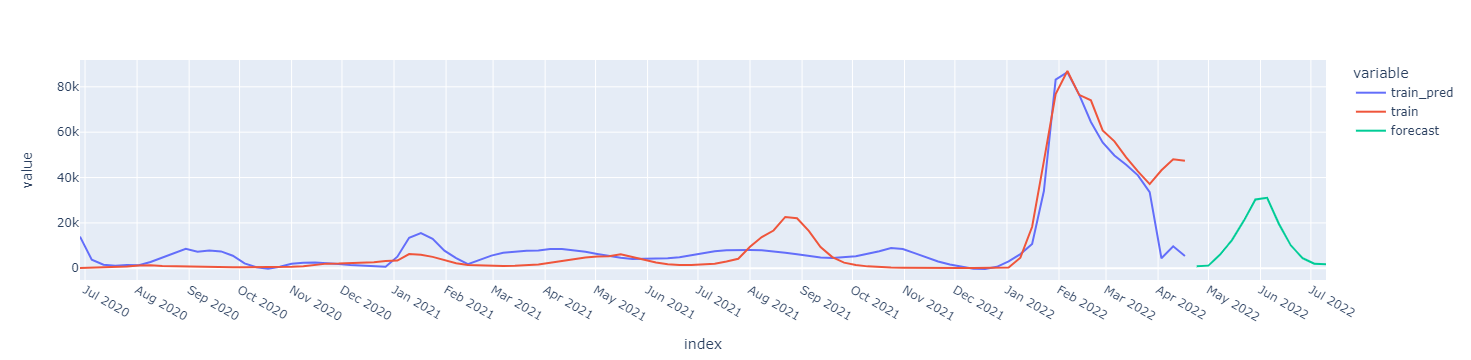

In [14]:
X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
y_train_index = y_train.index

y_pred = model.predict(X_train)
y_pred = sc.inverse_transform(y_pred).ravel()
y_pred = pd.Series(y_pred, index=y_train_index, name='train_pred')
y_train = sc.inverse_transform(y_train.values.reshape(-1, 1)).ravel()
y_train = pd.Series(y_train, index=y_train_index, name='train')

rmse = np.sqrt( mean_squared_error(y_train, y_pred) )
print('RMSE: {:.5}'.format(rmse))

X_forecast = X[X.index > last_date]
y_forecast = y[y.index > last_date]
y_forecast_index = y_forecast.index

y_forecast = model.predict(X_forecast)
y_forecast = sc.inverse_transform(y_forecast).ravel()
y_forecast = pd.Series(y_forecast, index=y_forecast_index, name='forecast')

# plt.plot(y_pred, label='train pred')
# plt.plot(y_train, label='test')
# plt.plot(y_forecast, label='forecast')
# plt.legend()

fig = px.line(pd.concat([y_pred, y_train, y_forecast], axis=1))
fig.update_layout({
    'xaxis': {
        'dtick': 'M1'
    }
})
fig.show()